# Predicting trends using pandas

We are going to compare and predict popularity change of trending web technologies and frameworks (Ruby on Rails, Node.js, Python/Django, PHP/Laravel).

Let’s first get some data from Google Trends. To download CSV file just click on button on the top left corner of chart, then choose CSV from drop-down menu.

First of all we are going to visualize data stored in CSV(`web-frameworks-trends.csv`), which we just have downloaded from Google Trends.

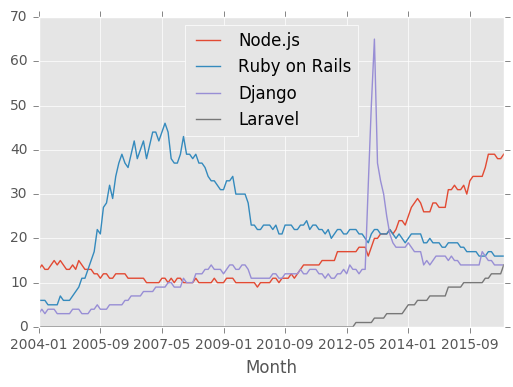

In [7]:
import sys
import datetime
import random as r
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame
from scipy.optimize import curve_fit

# Change charts style 
plt.style.use('ggplot')
# Load CSV data to DataFrame
df = pd.read_csv("web-frameworks-trends.csv")
# Set Index Column
df = df.set_index('Month')
# Plot line chart
df.plot.line()
plt.show()

To extrapolate the function we need to specify the end point of new function. One the way of doing this is filling out DataFrame by certain amount of rows(monthes) with NaN’s and generated dates.

In [9]:
def fill_with_NaNs(amount, data_frame):
  for column in range(amount):
    data_frame.loc[len(data_frame)] = [None for i in range(len(data_frame.columns))]
    
def generate_date_rows(base_date, amount):
  return np.array([(base_date + datetime.timedelta(i*365/12)).strftime("%Y-%m") for i in range(amount)])

df = pd.read_csv("web-frameworks-trends.csv").drop('Month', 1)
# Months
months = 24 # Five years
# Fill specified amount of rows of dataframe with NaN's 
fill_with_NaNs(months, df)
# Generate dates(Year-Month) for all rows from specified initial date
date_rows = generate_date_rows(datetime.datetime(2004, 1, 1), len(df.index))
# Add date to dataframe
df['Month'] = pd.Series(date_rows, index=df.index)
# Set Date as index column
df = df.set_index('Month')
df

,Node.js,Ruby on Rails,Django,Laravel
Month,,,,
2004-01,13.0,6.0,3.0,0.0
2004-01,14.0,6.0,4.0,0.0
2004-03,13.0,6.0,3.0,0.0
2004-04,13.0,5.0,4.0,0.0
2004-05,14.0,5.0,4.0,0.0
2004-06,15.0,5.0,4.0,0.0
2004-07,14.0,5.0,3.0,0.0
2004-07,15.0,7.0,3.0,0.0
2004-08,14.0,6.0,3.0,0.0


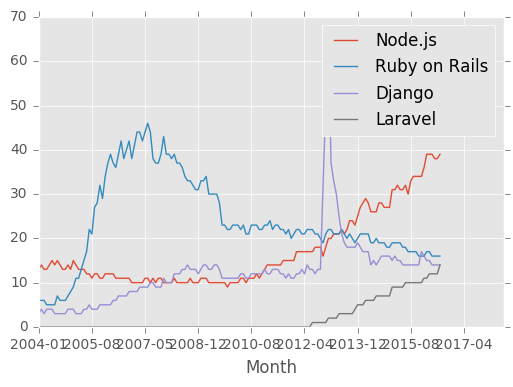

In [12]:
df.plot.line()
plt.show()

## EXTRAPOLATING FUNCTION

> In mathematics, extrapolation is the process of estimating, beyond the original observation range, the value of a variable on the basis of its relationship with another variable.

One way to extrapolate function is by curve fitting some general parameterized equation to the data to find parameter values. The limiting issue with this approach is that some assumption about trend must be made when the parameterized equation is selected. This can be found through trial and error or it can be inferred from the source of the data.

For now we’ll keep it simple and extrapolate function with 3rd order polynomial.
`f(x) = a x3 + b x2 + c x + d`

Here is an example of DataFrame extrapolation.

In [14]:
def cubic(x, a, b, c, d):
  return a * (x ** 3) + b * (x ** 2) + c * x + d

def extrapolate(data_frame):
  # Create copy of data to remove NaNs for curve fitting
  fit_df = data_frame.dropna()
  # Place to store function parameters for each column
  col_params = {}
  # Curve fit each column
  for col in fit_df.columns:
      # Get x & y
      x = fit_df.index.astype(float).values
      y = fit_df[col].values
      # Curve fit column and get curve parameters
      params = curve_fit(cubic, x, y)
      # Store optimized parameters
      col_params[col] = params[0]
  for col in data_frame.columns:
      # Get the index values for NaNs in the column
      x = data_frame[pd.isnull(data_frame[col])].index.astype(float).values
      # Extrapolate those points with the fitted function
      points = cubic(x, *col_params[col])
      data_frame[col][x] = points

In [15]:
df = pd.read_csv("web-frameworks-trends.csv").drop('Month', 1)
# Months
months = 24 # Five years
# Fill specified amount of rows of dataframe with NaN's 
fill_with_NaNs(months, df)
# Extrapolates dataframe
extrapolate(df)

In [16]:
df

,Node.js,Ruby on Rails,Django,Laravel
0,13.000000,6.000000,3.000000,0.000000
1,14.000000,6.000000,4.000000,0.000000
2,13.000000,6.000000,3.000000,0.000000
3,13.000000,5.000000,4.000000,0.000000
4,14.000000,5.000000,4.000000,0.000000
5,15.000000,5.000000,4.000000,0.000000
6,14.000000,5.000000,3.000000,0.000000
7,15.000000,7.000000,3.000000,0.000000
8,14.000000,6.000000,3.000000,0.000000
9,13.000000,6.000000,3.000000,0.000000


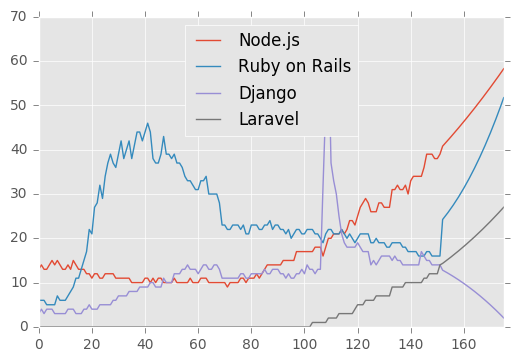

In [19]:
df.plot.line()
plt.show()

## ADDING RANDOM CHANGES

Typically, the quality of a particular method of extrapolation is limited by the assumptions about the function made by the method. If the method assumes the data are smooth, then a non-smooth function will be poorly extrapolated.

In the future we need to replace current polynomial extrapolation function with better one(some analytic extrapolation). But for now let’s just make our chat looks more “realistic” by adding some random changes to lines.

In [23]:
def load_data(csv_file):
  return pd.read_csv(csv_file).drop('Month', 1)

def normalize(points, min):
  for i in range(len(points)):
    if points[i] < min:
      points[i] = min + 0.1

def extrapolate(data_frame):
  # Create copy of data to remove NaNs for curve fitting
  fit_df = data_frame.dropna()
  # Place to store function parameters for each column
  col_params = {}
  # Curve fit each column
  for col in fit_df.columns:
      # Get x & y
      x = fit_df.index.astype(float).values
      y = fit_df[col].values
      # Curve fit column and get curve parameters
      params = curve_fit(cubic, x, y)
      # Store optimized parameters
      col_params[col] = params[0]
  for col in data_frame.columns:
      # Get the index values for NaNs in the column
      x = data_frame[pd.isnull(data_frame[col])] \
        .index.astype(float).values
      # Extrapolate those points with the fitted function
      points = cubic(x, *col_params[col])
      normalize(points, 0)
      # Add random changes
      for i in range(len(points)):
        if int(points[i]) % int(r.random() * 3 + 1) is 0:
          points[i] += r.random() * 4 - 2
      normalize(points, 0)
      data_frame[col][x] = points

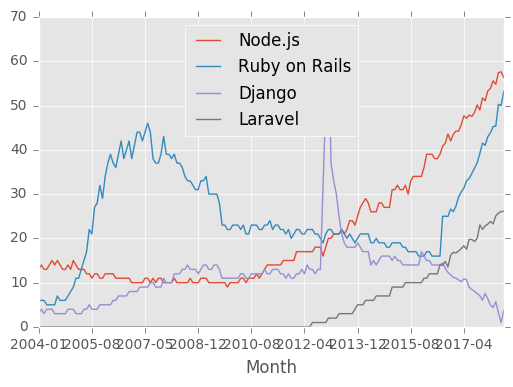

In [26]:
df = load_data("web-frameworks-trends.csv")
# Months
months = 24 # Five years
# Fill specified amount of rows of dataframe with NaN's 
fill_with_NaNs(months, df)
# Interpolate
df.interpolate()
# Extrapolate dataframe
extrapolate(df)
# Generate dates(Year-Month) for all rows from specified initial date
date_rows = generate_date_rows(datetime.datetime(2004, 1, 1), len(df.index))
# Add date to dataframe
df['Month'] = pd.Series(date_rows, index=df.index)
# Set Date as index column
df = df.set_index('Month')
# Plot line chart
df.plot.line()
plt.show()

In [27]:
df

,Node.js,Ruby on Rails,Django,Laravel
Month,,,,
2004-01,13.000000,6.000000,3.000000,0.000000
2004-01,14.000000,6.000000,4.000000,0.000000
2004-03,13.000000,6.000000,3.000000,0.000000
2004-04,13.000000,5.000000,4.000000,0.000000
2004-05,14.000000,5.000000,4.000000,0.000000
2004-06,15.000000,5.000000,4.000000,0.000000
2004-07,14.000000,5.000000,3.000000,0.000000
2004-07,15.000000,7.000000,3.000000,0.000000
2004-08,14.000000,6.000000,3.000000,0.000000
